# Homework 5 Solutions
#### Assigned: 2019-04-25
#### Due EOD: 2019-05-02

Based on Lecture 12
+ The student fills in the <...> fields.  
+ The student can create as many new cells as necessary in the solution sections.

**Make sure you have activated the correct python envorinment**

#### Name:  Michael Sotiropoulos
#### NetID: ms11620

## Problem 1 (20 points)

A CNN has the following structure:  

Conv2D_Layer -> Pooling_Layer -> Flattening_Layer -> Dense_Layer

+ input shape (size of the image): $M_1 \times M_2$
+ conv2d kernel with bias
+ conv2d kernel shape: $K_1 \times K_2$  
+ conv2d padding: same  
+ conv2d stride in both dimensions: 1  
+ conv2d filters (number of kernels): $F$
+ pooling layer size: $P_1 \times P_2$ (assume $P_{1,2}$ is a divisor of $M_{1,2}$) 
+ pooling padding: same
+ pooling stride in both dimensions: 1
+ flattening layer  
+ dense layer with bias
+ dense layer units (number of nodes): $H$

Write down the expression that gives the total number of parameters to be fitted $Q$ in terms of the above values.

## Solution 1

Number of parameters in Conv2D (kernel weights + bias): ($K_1 \times K_2 + 1)\times F$  
With same padding and stride=1, the shape of the feature map is: $M_1 \times M_2 \times F$  
Pooling with shape ($P_1$, $P_2$) and stride=1 reduces the shape of the feature map by $P_1$ and $P_2$ in each dimension: $M_1/P_1 \times M_2/P_2 \times F$  
Flattening vectorizes the feature map but does not change its size    
Densely connecting the vectorized feature map to the hidden layer adds: $M_1/P_1 \times M_2/P_2 \times F \times H$  
One bias parameter per hidden node, total: $H$  
Overall: 
$$ Q = (K_1 \times K_2 + 1) \times F + (M_1/P_1 \times M_2/P_2 \times F + 1) \times H$$

## Problem 2 (80 points) 

Use LSTM to analyze S&P 500 returns over the period 2004-2006.

The data file "stock-treasury-2004_2006.csv", to be found in the "Data" folder, contains the following:  
+ TREAS_3M: the yield of the 3-month treasury note in percent (i.e 2.1 means 2.1%)
+ Adjusted close price of ten major stocks: GM, F, UTX, CAT, MRK, PFE, IBM, MSFT, C, XOM
+ SP: The S&P 500 equity index level at the close of the trading day  

**Do the following:**  

Use the pandas read_csv function to read the Date and SP columns in a data frame called "sp_df".  
Rename the "SP" column into "ClosePx" in the same read_csv call.  
Compute the close-to-close index returns as:  $r_t = P_{t+1}/P_t - 1$ and add them as a new column "DailyRet".  
It is recommended to express all daily returns in basis points (10,000 bps = 100% = 1)

We want to train an RNN that looks back $M$ days and forecasts forward $N$ days.  
Therefore the RNN will use return sequences of size $M$, and targets of size $N$.  

Reformat the return data suitable for RNN processing as follows.  
From the "DailyRet" column of "sp_df", create a data input matrix $X$ containing rows as below:    
$$r_0, r_1, r_2, \ldots, r_{M-1}$$  
$$r_1, r_2, r_3, \ldots, r_{M}$$  
$$r_2, r_3, r_4, \ldots, r_{M+1}$$  
$$\ldots$$
From the "DailyRet" column of "sp_df", create also a target matrix $y$ containing rows as below:
$$ r_{M}, r_{M+1}, \ldots, r_{M+N-1}$$
$$ r_{M+1}, r_{M+2}, \ldots, r_{M+N}$$
$$ r_{M+2}, r_{M+3}, \ldots, r_{M+N+1}$$
$$\ldots$$

Set $M=16$ and $N=4$.  
Build an RNN with two LSTM cells and train it on the first 607 sequences.  
This means that the training set contains returns with the latest date of 2016-05-31.    
Use the remaining returns for out-of-sample testing.  
This is a regression task, so train the network using mean_squared_error loss.  
When connecting the two LSTMs, make sure you set the parameter return_sequences=True on the first LSTM, 
so that the second can see the sequences.

Compute the out-of-sample actual and predicted 2-day, 3-day, ..., N-day return, by summing 1-day forward returns up to this horizon.  
N-day return is the return from today's close to the close of the N-th day forward from today.  
Calculate and report the RMSE and the correlation between actual and predicted 1-day, 2-day, ..., N-day returns.  
Plot the actual and predicted returns in the out-of-sample part.  
What do you conclude regarding the quality of the forecasts?


## Solution 2

In [1]:
# data and stats packages
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
plt.style.use('ggplot')
# for cleaner display of returns
np.set_printoptions(precision=3, suppress=True) 

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
# load the SP prices
datapath = '../Data/stock-treasury-2004_2006.csv'
sp_df = pd.read_csv(datapath, header=0, names=['Date', 'ClosePx'], index_col=0, parse_dates=True, usecols=[0, 12])
# turn prices into one-period returns in basis points
# put the results inside a new data frame of returns
sp_df['DailyRet'] = 10000*(sp_df.ClosePx.diff() / sp_df.ClosePx).shift(-1)
# remove the last row, containint NaN
sp_df = sp_df.iloc[:-1, :]
# print a summary
sp_df.describe()

,ClosePx,DailyRet
count,672.000000,672.000000
mean,1196.774494,2.266926
std,65.175063,67.853694
min,1063.230000,-186.684001
25%,1137.957500,-40.630872
50%,1196.000000,6.784361
75%,1256.550000,44.381679
max,1325.760000,211.097755


## Reshape the data

In [3]:
M = 16         # size of the historic window
N = 4          # size of the forward window
imax = 608     # max index to use for training returns

# create the matrix of inpts
seqx = [np.array(sp_df.DailyRet[i:(i + M)]) for i in range(len(sp_df.DailyRet) - M - N + 1)]
X_train = np.asarray(seqx[0:imax - M])
X_test = np.asarray(seqx[imax - M:])
# create the matrix of targets
seqy = [np.array(sp_df.DailyRet[(i + M) : (i + M + N)]) for i in range(len(sp_df.DailyRet) - M - N + 1)]
y_train = np.asarray(seqy[0:imax - M])
y_test = np.asarray(seqy[imax - M:])

# add the third axis
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
#y_train = np.expand_dims(y_train, axis=2)
#y_test = np.expand_dims(y_test, axis=2)

print('data matrix shapes')
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test:  ', X_test.shape)
print('y_test:  ', y_test.shape)

data matrix shapes
X_train:  (592, 16, 1)
y_train:  (592, 4)
X_test:   (61, 16, 1)
y_test:   (61, 4)


## Network Construction

In [4]:
# parameters

input_shape = (M, 1)
units = 128
drop_rate = 0.1

rnn = Sequential()
rnn.add(LSTM(units, input_shape=input_shape, activation='relu', return_sequences=True))
rnn.add(LSTM(units, activation='relu'))
rnn.add(Dropout(drop_rate))
rnn.add(Dense(N))

rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16, 128)           66560     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 198,660
Trainable params: 198,660
Non-trainable params: 0
_________________________________________________________________


## Compile and fit the network

In [5]:
batch_size = 10
epochs = 40
val_split = 0.1
# create an early stopping callback
# es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None, restore_best_weights=False)

rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

rnn_hist = rnn.fit(X_train, y_train, batch_size = 10, epochs=epochs, validation_split=val_split, verbose=1)
rnn_val_score = rnn.evaluate(X_test, y_test, verbose=0)

print('LSTM')
print('------------------------')
print('Test loss score: {0:.4f}'.format(rnn_val_score[0]))
print('Test RMSE:   {0:.4f}'.format(rnn_val_score[1]))

Train on 532 samples, validate on 60 samples
Epoch 1/40
532/532 [==============================] - 3s 6ms/step - loss: 4462.2560 - acc: 0.2462 - val_loss: 4548.0518 - val_acc: 0.2167
Epoch 2/40
532/532 [==============================] - 1s 3ms/step - loss: 4408.7219 - acc: 0.2744 - val_loss: 4598.9334 - val_acc: 0.2333
Epoch 3/40
532/532 [==============================] - 1s 2ms/step - loss: 4396.9207 - acc: 0.2838 - val_loss: 4561.2289 - val_acc: 0.1667
Epoch 4/40
532/532 [==============================] - 1s 3ms/step - loss: 4303.5540 - acc: 0.2989 - val_loss: 4498.2884 - val_acc: 0.2333
Epoch 5/40
532/532 [==============================] - 1s 2ms/step - loss: 4198.9437 - acc: 0.3421 - val_loss: 4705.9449 - val_acc: 0.2167
Epoch 6/40
532/532 [==============================] - 2s 3ms/step - loss: 4103.2658 - acc: 0.3797 - val_loss: 4519.4356 - val_acc: 0.2833
Epoch 7/40
532/532 [==============================] - 1s 2ms/step - loss: 3951.2078 - acc: 0.3703 - val_loss: 4442.0680 - val_a

## Predictions

In [6]:
rnn_pred = rnn.predict(X_test)
act_rets = y_test
dats = sp_df.index[imax: -N + 1]

# put them in data frames for easy plotting
fcast = pd.DataFrame(index=dats, data = {'ActRet1D':act_rets[:,0], 'PredRet1D':rnn_pred[:,0]})
fcast['ActRet2D'] = fcast['ActRet1D'] + act_rets[:,1]
fcast['PredRet2D'] = fcast['PredRet1D'] + rnn_pred[:,1]
fcast['ActRet3D'] = fcast['ActRet2D'] + act_rets[:,2]
fcast['PredRet3D'] = fcast['PredRet2D'] + rnn_pred[:,2]
fcast['ActRet4D'] = fcast['ActRet3D'] + act_rets[:,3]
fcast['PredRet4D'] = fcast['PredRet3D'] + rnn_pred[:,3]


In [7]:
rmse = { '1d': [np.sqrt(mean_squared_error(fcast.ActRet1D, fcast.PredRet1D)), np.corrcoef(fcast.ActRet1D, fcast.PredRet1D)[0,1]]
        ,'2d': [np.sqrt(mean_squared_error(fcast.ActRet2D, fcast.PredRet2D)), np.corrcoef(fcast.ActRet2D, fcast.PredRet2D)[0,1]]
        ,'3d': [np.sqrt(mean_squared_error(fcast.ActRet3D, fcast.PredRet3D)), np.corrcoef(fcast.ActRet3D, fcast.PredRet3D)[0,1]]
        ,'4d': [np.sqrt(mean_squared_error(fcast.ActRet4D, fcast.PredRet4D)), np.corrcoef(fcast.ActRet4D, fcast.PredRet4D)[0,1]]
       }

print('RMSE')
display(pd.DataFrame.from_dict(rmse, orient='index', columns=['rmse', 'corr']))

RMSE


,rmse,corr
1d,85.458064,-0.057224
2d,110.600223,0.204459
3d,126.224698,0.186482
4d,139.206891,0.110382


### Plots

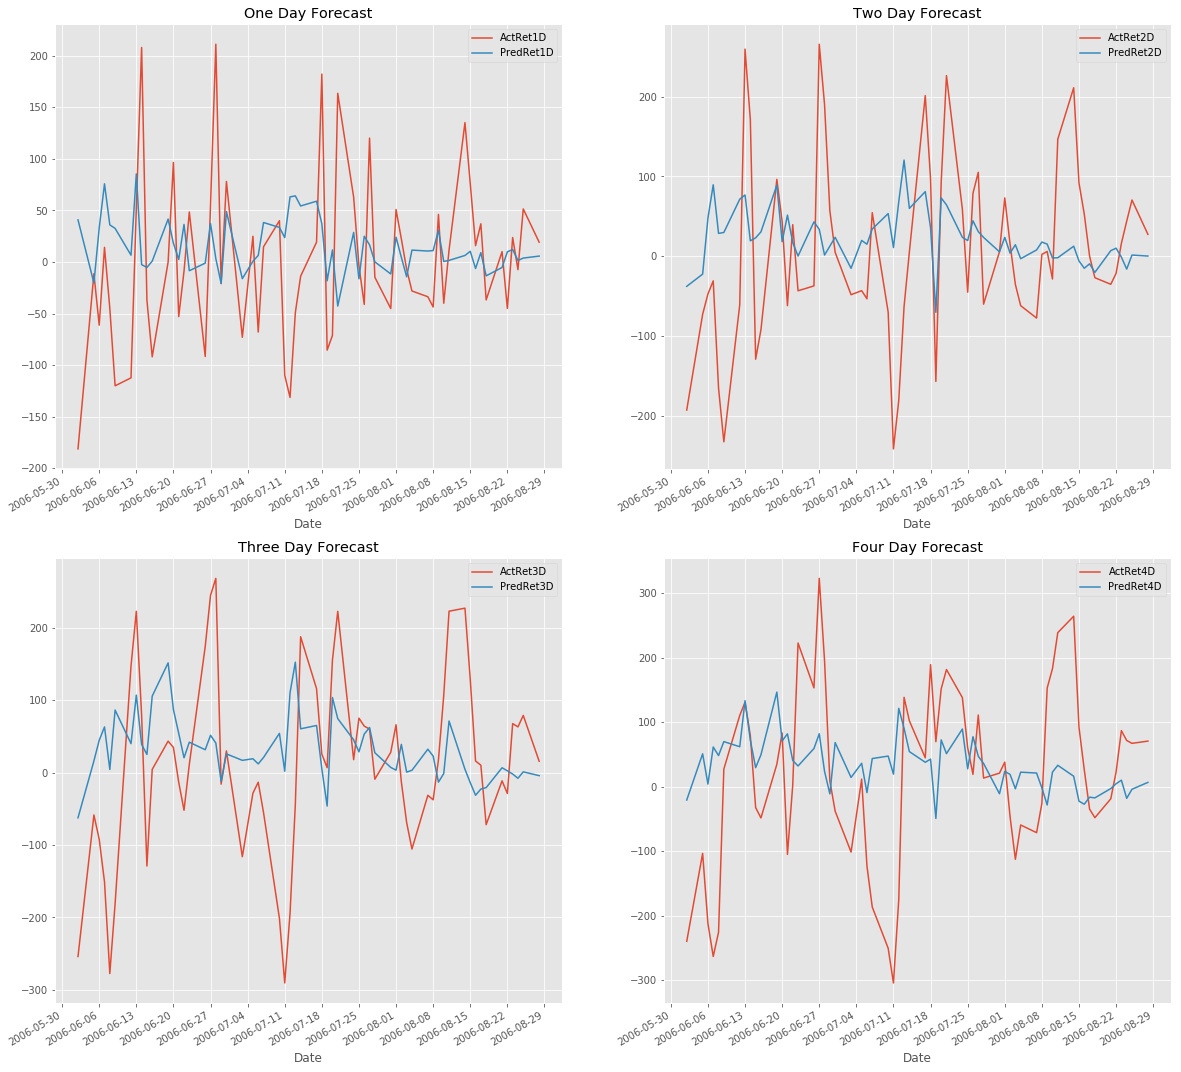

In [8]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fcast[['ActRet1D', 'PredRet1D']].plot(ax=ax1, title='One Day Forecast')
ax1.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=(1), interval=1))
fcast[['ActRet2D', 'PredRet2D']].plot(ax=ax2, title='Two Day Forecast')
ax2.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=(1), interval=1))
fcast[['ActRet3D', 'PredRet3D']].plot(ax=ax3, title='Three Day Forecast')
ax3.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=(1), interval=1))
fcast[['ActRet4D', 'PredRet4D']].plot(ax=ax4, title='Four Day Forecast')
ax4.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=(1), interval=1))

### Conclusion

The 2-LSTM RNN yields low correlation between actual and predicted returns and rather large RMSE.  
Occasionally, forecasting longer horizons may be more successful (higher correlation), but the results are unstable (re-run the notebook).